##          Московский авиационный институт
###      (Национальный исследовательский университет)
####   Институт №8 «Информационные технологии и прикладная математика»
####        Кафедра вычислительной математики и программирования

 
 
 








            Лабораторная работа № 8
            по курсу «Численные методы».
            
            Тема: «МЕТОД КОНЕЧНЫХ РАЗНОСТЕЙ
            РЕШЕНИЯ МНОГОМЕРНЫХ ЗАДАЧ МАТЕМАТИЧЕСКОЙ ФИЗИКИ».

 
 
 







                                Студент: Кондратьев Е.А.
                                Группа: 80-406Б
                                Преподаватель: Ревизников Д.Л.
                                Преподаватель: Пивоваров Д.Е.


 

                        Москва, 2022

# Лабораторная работа №8

***Задание:*** Используя схемы переменных направлений и дробных шагов, решить двумерную начально-краевую задачу для дифференциального уравнения параболического типа. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $u(x, y, t)$. Исследовать зависимость погрешности от сеточных параметров $\tau$ и $h_x$, $h_y$.

#### Вариант №4

In [24]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import math
import sys
import warnings
import numpy as np
import glob
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D
import plotly.offline as offline
from plotly.graph_objs import *

***Уравнение:***

$$\displaystyle\frac{\partial u}{\partial t} =  \displaystyle\frac{\partial^2 u}{\partial x^2} + \displaystyle\frac{\partial^2 u}{\partial y^2} - xy \sin{t}$$

***Граничные условия:***

\begin{equation*}
 \begin{cases}
   u (0, y, \: t) = \phi_0(y, t) = 0
   \\
   u (1, y, \: t) = \phi_1(y, t) = y \cos{t}
   \\
   u (x, 0, \: t) = \psi_0(x, t) = 0
   \\
   u(x, 1, \: t) = \psi_1(x, t) = x \cos{t}
   \\
   u(x, y, 0) = u_0 (x, y) = xy
 \end{cases}
\end{equation*}

***Аналитическое решение:***
$$u(x, y, t) = xy \cos{t}$$

In [25]:
def psi_0(x, t):
    return 0.0

# need to approx
def psi_1(x, t):
    return x * math.cos(t)

def phi_0(y, t):
    return 0.0

def phi_1(y, t):
    return y * math.cos(t)

def u0(x, y):
    return x*y

# analytic solve
def u(x, y, t):
    return x*y * math.cos(t)

## Конечно-разностная схема

[$0$, $l_x$] по координате $x$, [$0$, $l_y$] по координате $y$ и [$0$, $T$] по $t$.

Рассмотрим конечно-разностную схему решения краевой задачи на сетке с граничными параметрами $l_x$, $l_y$, $T$ и параметрами насыщенности сетки $N_x$, $N_y$, $K$.

Размер шага по каждой из координат определяется:
$$h_x = \displaystyle\frac{l_x}{N_x -1}, \; h_y = \displaystyle\frac{l_y}{N_y -1} , \; \tau = \displaystyle\frac{T}{K-1}$$


Конечно-разностная схема решения параболического типа в сетке на временном слое $t^{k+1}$ определяется с помощью 2-ух этапов, на каждом из которых решается трёхдиагональное уравнение с помощью метода прогонки:
- Считая, что значения функции

$u^k_{i, j} = u(x_i, y_j, t^k)$

на временном слое $t^{k}$ известно, попробуем определить значения функции на временном слое $t^{k + \frac{1}{2}}$ путем разностной аппроксимации производной по времени:

$\displaystyle\frac{\partial u}{\partial t}(x_i, y_j, t^k) = (1 + \gamma)\displaystyle\frac{u^{k+\frac{1}{2}}_{i, j} - u^{k}_{i, j}}{\tau}$,

неявной аппроксимацией производной по $x$: 

$\displaystyle\frac{\partial^2 u}{\partial x^2}(x_i, y_j, t^k) = \displaystyle\frac{u^{k+\frac{1}{2}}_{i-1, j} - 2 u^{k + \frac{1}{2}}_{i, j} + u^{k+\frac{1}{2}}_{i+1, j}}{h_x^2}$

и явной аппроксимацией по $y$:

$\displaystyle\frac{\partial^2 u}{\partial y^2}(x_i, y_j, t^k) = \displaystyle\frac{u^k_{i, j-1} - 2 u^k_{i, j} + u^k_{i, j+1}}{h_y^2}$

получаем уравнение:

$$(1 + \gamma)\displaystyle\frac{u^{k+\frac{1}{2}}_{i, j} - u^{k}_{i, j}}{\tau} = a\displaystyle\frac{u^{k+\frac{1}{2}}_{i-1, j} - 2 u^{k + \frac{1}{2}}_{i, j} + u^{k+\frac{1}{2}}_{i+1, j}}{h_x^2} +  a \gamma \displaystyle\frac{u^k_{i, j-1} - 2 u^k_{i, j} + u^k_{i, j+1}}{h_y^2}$$
$$ -a \tau h_x^2 \gamma u^{k}_{i, j-1} - ((1 + \gamma) h_x^2 h_y^2 - 2 a \tau h_x^2 \gamma) u^{k}_{i, j} - a \tau h_x^2 \gamma u^{k}_{i, j+1} + x_i y_j \sin{t^{k + \frac{1}{2}}} = $$ 
$$a \tau h_y^2 u^{k+\frac{1}{2}}_{i-1, j} - (2a \tau h_y^2 + (1 + \gamma) h_x^2 h_y^2) u^{k+\frac{1}{2}}_{i, j} + a \tau h_y^2 u^{k+\frac{1}{2}}_{i+1, j}$$


- Известны значения функции $u^{k+\frac{1}{2}}_{i, j} = u(x_i, y_j, t^{k+\frac{1}{2}})$ на временном слое $t^{k + \frac{1}{2}}$ то, определим значения функции на временном слое $t^{k + 1}$ путем разностной аппроксимации производной по времени:

$\displaystyle\frac{\partial u}{\partial t}(x_i, y_j, t^{k+\frac{1}{2}}) = (1 + \gamma)\displaystyle\frac{u^{k+1}_{i, j} - u^{k+\frac{1}{2}}_{i, j}}{\tau}$, 

явной аппроксимацией производной по $x$:

$\displaystyle\frac{\partial^2 u}{\partial x^2}(x_i, y_j, t^{k+\frac{1}{2}}) = \displaystyle\frac{u^{k+\frac{1}{2}}_{i-1, j} - 2 u^{k + \frac{1}{2}}_{i, j} + u^{k+\frac{1}{2}}_{i+1, j}}{h_x^2}$

и неявной аппроксимацией по $y$: 

$\displaystyle\frac{\partial^2 u}{\partial y^2}(x_i, y_j, t^{k+\frac{1}{2}}) = \displaystyle\frac{u^{k+1}_{i, j-1} - 2 u^{k+1}_{i, j} + u^{k+1}_{i, j+1}}{h_y^2}$

получим второе уравнение:

$$ -a \tau h_y^2 \gamma u^{k+\frac{1}{2}}_{i-1, j} - ((1 + \gamma) h_x^2 h_y^2 - 2 a \tau h_y^2 \gamma) u^{k + \frac{1}{2}}_{i, j} - a \tau h_y^2 \gamma u^{k+\frac{1}{2}}_{i+1, j} = $$
$$a \tau h_x^2 u^{k+1}_{i, j-1} - (2a \tau h_x^2 + (1 + \gamma) h_x^2 h_y^2) u^{k+1}_{i, j} + a \tau h_x^2 u^{k+1}_{i, j+1}$$

$\gamma = 1$ - метод переменных направлений

$\gamma = 0$ - метод дробных шагов.

## Реализация

In [26]:
class Schema:
    def __init__(self, rho = u0, psi0 = psi_0, psi1 = psi_1, phi0 = phi_0, phi1 = phi_1,
                 lx0 = 0, lx1 = 1.0, ly0 = 0, ly1 = 1.0, T = 3, order2nd = True):
        self.psi0 = psi0
        self.psi1 = psi1
        self.phi0 = phi0
        self.phi1 = phi1
        self.rho0 = rho
        self.T = T
        self.lx0 = lx0
        self.lx1 = lx1
        self.ly0 = ly0
        self.ly1 = ly1
        self.tau = None
        self.hx = None
        self.hy = None
        self.order = order2nd
        self.Nx = None
        self.Ny = None
        self.K = None
        self.cx = None
        self.bx = None
        self.cy = None
        self.by = None
        self.hx2 = None
        self.hy2 = None
        
        
    def set_l0_l1(self, lx0, lx1, ly0, ly1):
        self.lx0 = lx0
        self.lx1 = lx1
        self.ly0 = ly0
        self.ly1 = ly1
        
    def set_T(self, T):
        self.T = T
        
    def CalculateH(self):
        self.hx = (self.lx1 - self.lx0) / (self.Nx - 1)
        self.hy = (self.ly1 - self.ly0) / (self.Ny - 1)
        self.hx2 = self.hx * self.hx
        self.hy2 = self.hy * self.hy
        
    def CalculateTau(self):
        self.tau = self.T / (self.K - 1)
        
    @staticmethod
    def race_method(A, b):
        P = [-item[2] for item in A]
        Q = [item for item in b]
        P[0] /= A[0][1]
        Q[0] /= A[0][1]
        for i in range(1, len(b)):
            z = (A[i][1] + A[i][0] * P[i-1])
            P[i] /= z
            Q[i] -= A[i][0] * Q[i-1]
            Q[i] /= z
        for i in range(len(Q) - 2, -1, -1):
            Q[i] += P[i] * Q[i + 1]
        return Q    
      
    @staticmethod
    def nparange(start, end, step = 1):
        now = start
        e = 0.00000000001
        while now - e <= end:
            yield now
            now += step
            
    def CalculateLeftEdge(self, X, Y, t, square):
        for i in range(self.Ny):
            square[i][0] = self.phi0(Y[i][0], t)
            
    def CalculateRightEdge(self, X, Y, t, square):
        for i in range(self.Ny):
            square[i][-1] = self.phi1(Y[i][-1], t)
            
    def CalculateBottomEdge(self, X, Y, t, square):
        for j in range(1, self.Nx - 1):
            square[0][j] = self.psi0(X[0][j], t)
            
    def CalculateTopEdge(self, X, Y, t, square):
        for j in range(1, self.Nx - 1):
            square[-1][j] = self.psi1(X[-1][j], t)
            
            
    def CalculateLineFirstStep(self, i, X, Y, t, last_square, now_square):
        hy2 = self.hy2
        hx2 = self.hx2
        b = self.bx
        c = self.cx
        A = [(0, b, c)]
        w = [
            -self.cy*self.order*last_square[i-1][1] -
            ((self.order + 1)*hx2*hy2 - 2*self.cy*self.order)*last_square[i][1] -
            self.cy*self.order*last_square[i+1][1] +
            self.tau*hy2*hx2*X[i][1]*Y[i][1]*math.sin(t) - 
            c*now_square[i][0]
        ]
        A.extend([(c, b, c) for _ in range(2, self.Nx - 2)])
        w.extend([
            -self.cy*self.order*last_square[i-1][j] -
            ((self.order + 1)*hx2*hy2 - 2*self.cy*self.order)*last_square[i][j] -
            self.cy*self.order*last_square[i+1][j] + 
            self.tau*hy2*hx2*X[i][j]*Y[i][j]*math.sin(t)
            for j in range(2, self.Nx - 2)
        ])
        A.append((c, b, 0))
        w.append(
            -self.cy*self.order*last_square[i-1][-2] -
            ((self.order + 1)*hx2*hy2 - 2*self.cy*self.order)*last_square[i][-2] -
            self.cy*self.order*last_square[i+1][-2] +
            self.tau*hy2*hx2*X[i][-2]*Y[i][-2]*math.sin(t) - 
            c*now_square[i][-1]
        )
        line = self.race_method(A, w)
        for j in range(1, self.Nx - 1):
            now_square[i][j] = line[j - 1]
            
    def CalculateLineSecondStep(self, j, X, Y, t, last_square, now_square):
        hx2 = self.hx2
        hy2 = self.hy2
        c = self.cy
        b = self.by
        A = [(0, b, c)]
        w = [
            -self.cx*self.order*last_square[1][j - 1] -
            ((self.order + 1)*hx2*hy2 - 2*self.cx*self.order)*last_square[1][j] -
            self.cx*self.order*last_square[1][j + 1] +
            self.tau*hy2*hx2*X[1][j]*Y[1][j]*math.sin(t) - 
            c*now_square[0][j]
        ]
        A.extend([(c, b, c) for _ in range(2, self.Ny - 2)])
        w.extend([
            -self.cx*self.order*last_square[i][j - 1] -
            ((self.order + 1)*hx2*hy2 - 2*self.cx*self.order)*last_square[i][j] -
            self.cx*self.order*last_square[i][j + 1] + 
            self.tau*hy2*hx2*X[i][j]*Y[i][j]*math.sin(t)
            for i in range(2, self.Ny - 2)
        ])
        A.append((c, b, 0))
        w.append(
            -self.cx*self.order*last_square[-2][j - 1] -
            ((self.order + 1)*hx2*hy2 - 2*self.cx*self.order)*last_square[-2][j] -
            self.cx*self.order*last_square[-2][j + 1] +
            self.tau*hy2*hx2*X[-2][j]*Y[-2][j]*math.sin(t) - 
            c*now_square[-1][j]
        )
        line = self.race_method(A, w)
        for i in range(1, self.Ny - 1):
            now_square[i][j] = line[i - 1]
    
        
    def CalculateSquare(self, X, Y, t, last_square):
        square = [[0.0 for _ in range(self.Nx)] for _ in range(self.Ny)]
        self.CalculateLeftEdge(X, Y, t - 0.5*self.tau, square)
        self.CalculateRightEdge(X, Y, t - 0.5*self.tau, square)
        self.CalculateBottomEdge(X, Y, t - 0.5*self.tau, square)
        self.CalculateTopEdge(X, Y, t - 0.5*self.tau, square)
        for i in range(1, self.Ny - 1):
            self.CalculateLineFirstStep(i, X, Y, t - 0.5*self.tau, last_square, square)
        last_square = square
        square = [[0.0 for _ in range(self.Nx)] for _ in range(self.Ny)]
        self.CalculateLeftEdge(X, Y, t, square)
        self.CalculateRightEdge(X, Y, t, square)
        self.CalculateBottomEdge(X, Y, t, square)
        self.CalculateTopEdge(X, Y, t, square)
        for j in range(1, self.Nx - 1):
            self.CalculateLineSecondStep(j, X, Y, t, last_square, square)
        return square
        
    
    def init_t0(self, X, Y):
        first = [[0.0 for _ in range(self.Nx)] for _ in range(self.Ny)]
        for i in range(self.Ny):
            for j in range(self.Nx):
                first[i][j] = self.rho0(X[i][j], Y[i][j])
        return first
        
        
    
    def __call__(self, Nx=20, Ny=20, K=20):
        self.Nx, self.Ny, self.K = Nx, Ny, K 
        self.CalculateTau()
        self.CalculateH()
        
        self.bx = -2*self.tau*self.hy2
        self.bx -= (1 + self.order)*self.hx2*self.hy2
        self.cx = self.tau * self.hy2
        
        self.cy = self.tau * self.hx2
        self.by = -2*self.tau*self.hx2
        self.by -= (1 + self.order)*self.hx2*self.hy2
        x = list(self.nparange(self.lx0, self.lx1, self.hx))
        y = list(self.nparange(self.ly0, self.ly1, self.hy))
        X = [x for _ in range(self.Ny)]
        Y = [[y[i] for _ in x] for i in range(self.Ny)]
        
        taus = [0.0]
        ans = [self.init_t0(X, Y)]
        for t in self.nparange(self.tau, self.T, self.tau):
            ans.append(self.CalculateSquare(X, Y, t, ans[-1]))
            taus.append(t)
        return X, Y, taus, ans

## Результаты

#### Зависимость значений метода от параметров

Реальное значение функции на плоскости в определённый момент времени:

In [27]:
def RealZByTime(lx0, lx1, ly0, ly1, t, f):
    x = np.arange(lx0, lx1 + 0.002, 0.002)
    y = np.arange(ly0, ly1 + 0.002, 0.002)
    X = np.ones((y.shape[0], x.shape[0]))
    Y = np.ones((x.shape[0], y.shape[0]))
    Z = np.ones((y.shape[0], x.shape[0]))
    for i in range(Y.shape[0]):
        Y[i] = y
    Y = Y.T
    for i in range(X.shape[0]):
        X[i] = x
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = f(X[i, j], Y[i, j], t)
    return X, Y, Z

#### Вычисление погрешностей

<!-- Значение погрешности в определённый момент времени вычислим как:

$RMSE = \sqrt{\displaystyle\frac{\sum\limits^{N_x}_{i = 0} \sum\limits^{N_y}_{j = 0} (u_{i, j} - \hat{u_{i, j}})^2}{N_x N_y}}$ по площади.

def ErrorRMSE(X, Y, t, z, ut = u):
    ans = 0.0
    for i in range(len(z)):
        for j in  range(len(z[i])):
            ans += (ut(X[i][j], Y[i][j], t) - z[i][j])**2
    return (ans / len(z) / len(z[0]))**0.5
    
Значение погрешности в определённый момент времени вычислим как:

$MSE = {\displaystyle\frac{\sum\limits^{N_x}_{i = 0} \sum\limits^{N_y}_{j = 0} (u_{i, j} - \hat{u_{i, j}})^2}{N_x N_y}}$ по площади.

def ErrorMSE(X, Y, t, z, ut = u):
    ans = 0.0
    for i in range(len(z)):
        for j in  range(len(z[i])):
            ans += (ut(X[i][j], Y[i][j], t) - z[i][j])**2
    return (ans / len(z) / len(z[0])) -->

Значение погрешности в определённый момент времени вычислим как:

${\displaystyle\frac{\sum\limits^{N_x}_{i = 0} \sum\limits^{N_y}_{j = 0} max|(u_{i, j} - \hat{u_{i, j}})|}{N_x N_y}}$ по площади.

In [28]:
def Error(X, Y, t, z, ut = u):
    ans = 0.0
    for i in range(len(z)):
        for j in  range(len(z[i])):
            ans = max(abs(ut(X[i][j], Y[i][j], t) - z[i][j]), ans)
    return (ans / len(z) / len(z[0]))

Визуализируем полученные значения и искомую зависимость с помощи данных функций:

In [29]:
def StepSlice(lst, step):
    return lst[step]

def AnimateList(lst, play=False, interval=200):
    slider = widgets.IntSlider(min=0, max=len(lst) - 1, step=1, value=0)
    if play:
        play_widjet = widgets.Play(interval=interval)
        widgets.jslink((play_widjet, 'value'), (slider, 'value'))
        display(play_widjet)
        # slider = widgets.Box([play_widject, slider])
    return interact(StepSlice,
                    lst=fixed(lst),
                    step=slider)

In [30]:
def PlotByTime(X, Y, T, Z, j, extrems, plot_true = True):
    t = T[j]
    z = Z[j]
    fig = plt.figure(num=1, figsize=(20, 13), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(np.array(X), np.array(Y), np.array(z))
    if plot_true:
        ax.plot_wireframe(*RealZByTime(0, 1, 0, 1, t, u), color="green")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z') 
    ax.set_title(
        't = ' + str(round(t, 8)) + " error = " + str(round(Error(X, Y, t, z), 11)), 
        loc = "right", fontsize=25
    )
    ax.set_zlim(extrems[0], extrems[1])
    fig.tight_layout()
    plt.close(fig)
    return fig

def SquareMinMax(z):
    minimum, maximum = z[0][0], z[0][0]
    for i in range(len(z)):
        for j in range(len(z[i])):
            minimum = z[i][j] if z[i][j] < minimum else minimum
            maximum = z[i][j] if z[i][j] > maximum else maximum
    return minimum, maximum

def SearchMinMax(zz):
    minimum, maximum = 0.0, 0.0
    for z in zz:
        minmax = SquareMinMax(z)
        minimum = minmax[0] if minmax[0] < minimum else minimum
        maximum = minmax[1] if minmax[1] > maximum else maximum
    return minimum, maximum
        

def PlotAnimate(nx = 15, ny = 15, k=50, t=5, plot_true = False):
    schema = Schema(T = t, order2nd = True)
    xx, yy, tt, zz = schema(Nx = nx, Ny = ny, K = k)
    extrems = SearchMinMax(zz)
    plots = []
    for j in range(len(tt)):
        plots.append(PlotByTime(xx, yy, tt, zz, j, extrems, plot_true))
    AnimateList(plots, play=True, interval=2000)

В зависимости от параметров полученное приближение будет иметь следующий вид:

In [31]:
interact(
    PlotAnimate, 
    nx=(5, 200, 2), 
    ny=(5, 200, 2),
    k=(20, 200, 5), 
    t = (1, 10, 1), 
    plot_true = [False, True]
)
None

interactive(children=(IntSlider(value=15, description='nx', max=200, min=5, step=2), IntSlider(value=15, descr…

#### Зависимость погрешности расчетов от параметров 

In [32]:
first = Schema(T = 2*math.pi, order2nd = False) #метод дробных шагов
second = Schema(T = 2*math.pi, order2nd = True) #метод переменных направлений

#### Построение зависимости погрешности от шага $h_x, \; h_y$.

Сетки значений погрешности и соответствующих длин шагов получим с помощью функции:

In [33]:
def GetGraphicH(solver, time = 0, tsteps = 40):
    h, e = [], []
    for N in range(4, 20, 1):
        x, y, t, z = solver(Nx = N, Ny = N, K = tsteps)
        h.append(solver.hx)
        e.append(Error(x, y, t[time], z[time]))
    return h, e

In [34]:
TSTEPS = 100
time = random.randint(0, TSTEPS - 1)
h1, e1 = GetGraphicH(first, time, TSTEPS)
h2, e2 = GetGraphicH(second, time, TSTEPS)

Зависимость погрешности от длины шагов по координате при фиксированном шаге по времени в методе дробных шагов и переменных направлений:

In [35]:
trace1 = Scatter(
    x = h1,
    y = e1,
    line= dict(width=3),
    name = 'Метод дробных шагов',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

trace2 = Scatter(
    x = h2,
    y = e2,
    line= dict(width=3.7),
    name = 'Метод переменных направлений',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

data = [trace1, trace2]

layout = Layout(
    title = 'Зависимость погрешности от длины шага по координате',
    xaxis = dict(title = '$h_x$'),
    yaxis = dict(title = '$\epsilon$'),
    plot_bgcolor = 'darkgray',
    paper_bgcolor = 'gray'
)

fig = Figure(data = data, layout = layout)
offline.iplot(fig)

trace1 = Scatter(
    x = list(map(math.log, h1)),
    y = list(map(math.log, e1)),
    name = 'Метод дробных шагов',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

trace2 = Scatter(
    x = list(map(math.log, h2)),
    y = list(map(math.log, e2)),
    name = 'Метод переменных направлений',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

data = [trace1, trace2]

layout = Layout(
    title = 'Зависимость погрешности от длины шага по координате',
    xaxis = dict(title = '$\log{h_x}$'),
    yaxis = dict(title = '$\log{\epsilon}$'),
    plot_bgcolor = 'darkgray',
    paper_bgcolor = 'gray'
)

fig = Figure(data = data, layout = layout)
offline.iplot(fig)

#### Построение зависимости погрешности от $\tau$

In [36]:
def GetGraphicTau(solver):
    tau = []
    e = []
    for K in range(15, 100, 2):
        x, y, t, z = solver(Nx = 10, Ny = 10, K = K)
        tau.append(solver.tau)
        time = K // 2
        e.append(Error(x, y, t[time], z[time]))
    return tau, e

Зависимость погрешности от длины шага по времени при фиксированных шагах по координатам в методе дробных шагов и переменных направлений:

In [37]:
tau1, e1 = GetGraphicTau(first)
tau2, e2 = GetGraphicTau(second)

In [38]:
trace1 = Scatter(
    x = tau1,
    y = e1,
    line= dict(width=3),
    name = 'Метод дробных шагов',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

trace2 = Scatter(
    x = tau2,
    y = e2,
    line= dict(width=3.7),
    name = 'Метод переменных направлений',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

data = [trace1, trace2]

layout = Layout(
    title = 'Зависимость погрешности от длины шага по времени',
    xaxis = dict(title = '$h_x$'),
    yaxis = dict(title = '$\epsilon$'),
    plot_bgcolor = 'darkgray',
    paper_bgcolor = 'gray'
)

fig = Figure(data = data, layout = layout)
offline.iplot(fig)

trace1 = Scatter(
    x = list(map(math.log, tau1)),
    y = list(map(math.log, e1)),
    name = 'Метод дробных шагов',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

trace2 = Scatter(
    x = list(map(math.log, tau2)),
    y = list(map(math.log, e2)),
    name = 'Метод переменных направлений',
    mode = 'lines',
    text = ('(x, y)'),
    showlegend = True
)

data = [trace1, trace2]

layout = Layout(
    title = 'Зависимость погрешности от длины шага по времени',
    xaxis = dict(title = '$\log{h_x}$'),
    yaxis = dict(title = '$\log{\epsilon}$'),
    plot_bgcolor = 'darkgray',
    paper_bgcolor = 'gray'
)

fig = Figure(data = data, layout = layout)
offline.iplot(fig)

#### Общая зависимость погрешности от сеточных параметров

График зависимости погрешности от параметров шага по координате и времени:

In [39]:
def FullError(X, Y, T, Z):
    ans = 0.0
    for k in range(len(T)):
        for i in range(len(X)):
            for j in range(len(X[i])):
                ans = max(abs(u(X[i][j], Y[i][j], T[k]) - Z[k][i][j]), ans)
    return (ans / len(T) / len(X) / len(X[0]))

In [40]:
TimeList = [random.randint(0, 40 - 1) for i in range(4)]
def plotDependenceError(Nx=4, Ny=4, K=40, Method=0):
    NxFix = Nx
    NyFix = Ny
    if Method != 0:
        method = True
        stri = 'Погрешность метода переменных направлений'
    else:
        method = False
        stri = 'Погрешность метода дробных шагов'
    plt.figure(figsize=(6, 12))
    for i in range(1, 4):
        plt.subplot(5, 1, i)
        Time = TimeList[i-1]#random.randint(0, K - 1)
        schema = Schema(T=Time, order2nd=method)
        h, eps = [], []
        for j in range(10):
            h.append([])
            eps.append([])
            X, Y, T, Z = schema(Nx, Ny, K)
            Nx += 1
            Ny += 1
            h[-1].append(schema.hx)
            eps[-1].append(Error(X, Y, T[Time], Z[Time]))
        Nx = NxFix
        Ny = NyFix
        plt.plot(np.array(h), np.array(eps), label="const T = " + str(round(T[Time])))
        plt.xlabel('$h$')
        plt.ylabel('$\epsilon$')
        plt.title(stri)
        plt.legend()
        plt.grid()
        plt.show()
interact(plotDependenceError, Nx=(4, 120, 2), Ny=(4,120, 2), K=(40, 160, 40), Method=(0,1))
None

interactive(children=(IntSlider(value=4, description='Nx', max=120, min=4, step=2), IntSlider(value=4, descrip…

100%|██████████| 20/20 [01:01<00:00,  3.10s/it]


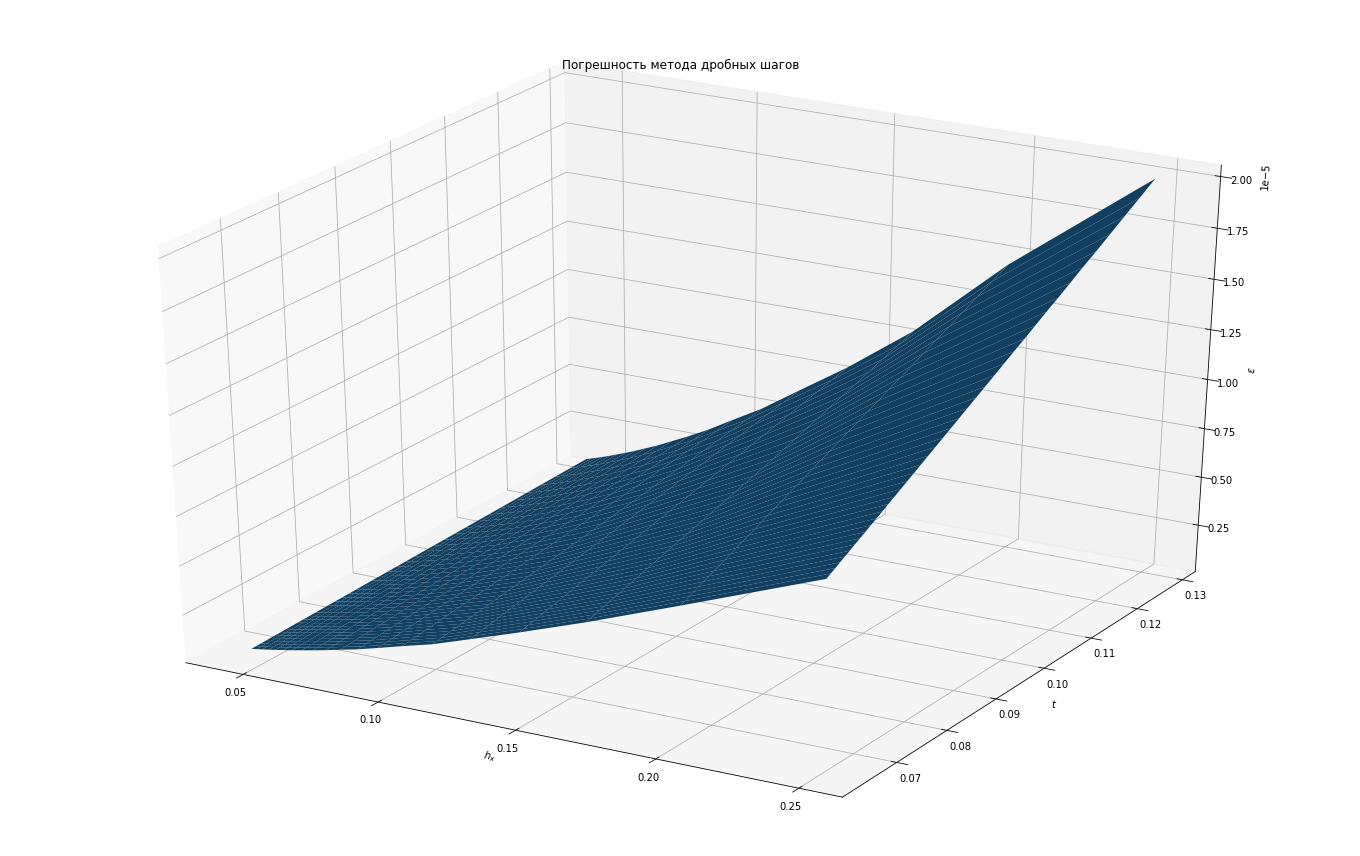

In [41]:
def PlotError():
    schema = Schema(T = 5, order2nd=False)
    h = []
    tau = []
    eps = []
    for i in tqdm(range(20)):
        h.append([])
        tau.append([])
        eps.append([])
        for j in range(40):
            N = i + 5
            K = j + 40
            X, Y, T, Z = schema(N, N, K)
            h[-1].append(schema.hx)
            tau[-1].append(schema.tau)
            eps[-1].append(FullError(X, Y, T, Z))

    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(np.array(h), np.array(tau), np.array(eps))
    ax.set(xlabel='$h_x$', ylabel='$t$', zlabel='$\epsilon$', title='Погрешность метода дробных шагов')
    fig.tight_layout()

PlotError()

***Вывод:*** Используя схемы переменных направлений и дробных шагов, научился решать двумерную начально-краевую задачу для дифференциального уравнения параболического типа. Вычислил погрешности в различные моменты времени и исследовал зависимость погрешность от различных параметров $\tau$ и $h_x$, $h_y$.